In [22]:
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import Ridge
from scipy.stats import uniform
from sklearn.pipeline import FeatureUnion

from sklearn.compose import make_column_selector
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV

from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split

from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import FunctionTransformer

from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
import joblib
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

In [9]:
df = pd.read_csv('../Covid_19/data/covid_19_patient_features_v5.csv')

In [3]:
df.set_index('patient_no', inplace=True, drop=True)

In [4]:
df.head(5)

,Hospital,Age,Gender,Body_temperature,Underlying_diseases,SARS-CoV-2_nucleic_acids,CT,Morbidity,Mortality,MCHC,...,UNCC,BYST,MS-U,UNCX,URBC,UWBC,SG,PH,WBCC,BACT
patient_no,,,,,,,,,,,,,,,,,,,,,
Patient 1,Union,81,Male,36.6,"Hypertension, Thyroidectomy",Positive,Positive,Regular,Cured,344.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Patient 2,Union,50,Male,38.7,No,Positive,Positive,Regular,Cured,349.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Patient 3,Union,65,Female,38.5,Postoperative cervical cancer,Positive,Positive,Regular,Cured,330.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Patient 4,Union,73,Male,38.5,Aorta calcification,Positive,Positive,Severe,Cured,337.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Patient 5,Union,64,Female,38.0,No,Positive,Positive,Severe,Cured,329.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [5]:
#pd.set_option('display.max_rows', None)
#pd.set_option('display.max_columns', None)

## Morbidity plot from dataframe

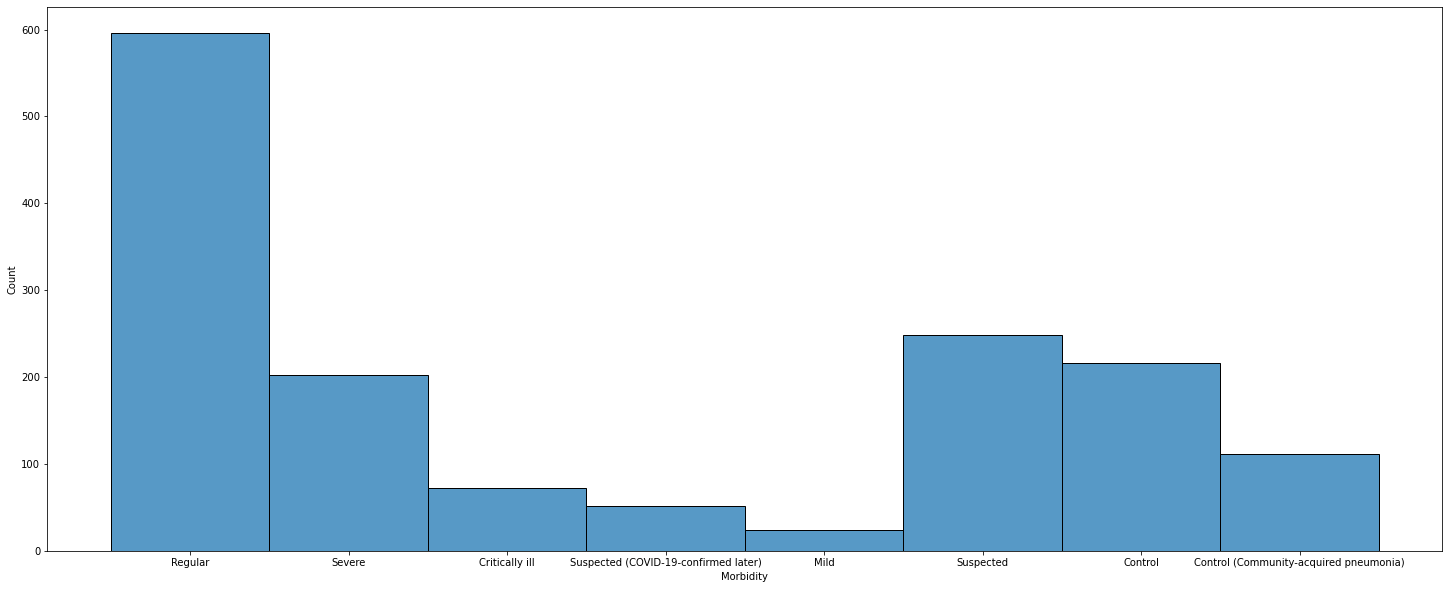

In [6]:
plt.figure(figsize=(25,10))
sns.histplot(df['Morbidity'])
plt.show()

Regular category is too high, unbalanced data.
Will reduce by half.

Checking proportion of Covid19 postive vs negative case for all patient in the Morbitidy column

In [7]:
pd.crosstab(df['Morbidity'], df['SARS-CoV-2_nucleic_acids'])

SARS-CoV-2_nucleic_acids,Negative,Negative; Positive (Confirmed later),Positive
Morbidity,,,
Control,216,0,0
Control (Community-acquired pneumonia),112,0,0
Critically ill,0,0,72
Mild,0,0,24
Regular,0,0,596
Severe,0,0,202
Suspected,248,0,0
Suspected (COVID-19-confirmed later),0,51,0


In [8]:
pd.crosstab(df['Mortality'], df['SARS-CoV-2_nucleic_acids'])

SARS-CoV-2_nucleic_acids,Negative,Negative; Positive (Confirmed later),Positive
Mortality,,,
Cured,0,0,662
Deceased,0,0,57
Unknown,576,51,175


We will drop all 'suspected' (248 patients) because they are negative as well as the 'Suspected (COVID-19-confirmed later)' that turned out positive, because we do not have any detail on the morbidity status (51 patients)

#### Setting mortality target

In [9]:

df = df[df['Mortality']!='Unknown']

# le = LabelEncoder()
# df['target_mortality'] = le.fit_transform(df['Mortality'])

In [10]:
df['Mortality'].value_counts()

Cured       662
Deceased     57
Name: Mortality, dtype: int64

## Pipeline

### Preprocessing

In [11]:
def clean(df):
    for feature in df.columns:
        try:
            df[feature] = df[feature].str.replace('>','')
            df[feature] = df[feature].str.replace('<','')
        except AttributeError:
            pass
        df[feature] = df[feature].astype(float)
    return df
    
def target_set(df):
    df['target']=np.where(df['Mortality']=='Cured', 0, 1)
    return df[['target']]

def select_feature(df):
    return df[selected_features]

def cast_to_df(df):
    return pd.DataFrame(df, columns=["target"]+selected_features)

In [12]:
selected_features = ['NEP', 'Age', 'LDH', 'NE', 'LYP', 'LY', 'ALB', 'EOP', 'EO', 'ALG', 'CA', 'MOP', 'INR', 'BUN', 'TBIL', 'WBC', 'DD']

pipe_clean = Pipeline([
    ('selector1', FunctionTransformer(select_feature)),
    ('clean', FunctionTransformer(clean)),
])

pipe_target = Pipeline([
    ('target', FunctionTransformer(target_set) ) 
    ])

fu = FeatureUnion([('pipe_target', pipe_target),('pipe_clean', pipe_clean)])

staging_pipe = Pipeline([('featureUnion', fu),
                    ('cast_to_df',FunctionTransformer(cast_to_df))
                    ])

In [13]:
num_transformer = Pipeline([
    ('imputer', SimpleImputer(strategy='constant', fill_value=-1)),
    ('scaler', StandardScaler())
])

cat_transformer = Pipeline([
    ('inputer_object', SimpleImputer(strategy='constant', fill_value='unknown')),
    ('cat_encoder', OneHotEncoder(handle_unknown='ignore', sparse=False))
])

preprocessor = ColumnTransformer([
    ('num_transformer', num_transformer, make_column_selector(dtype_include="float64")),
    ('cat_transformer', cat_transformer, make_column_selector(dtype_include=['object', 'O']))],
     remainder='passthrough')
    


final_pipe = Pipeline([
    ('preprocessing', preprocessor),
    ('linear_classification', LogisticRegression(max_iter=5000))
    ])

In [14]:
df_staging=staging_pipe.fit_transform(df)

X = df_staging.drop(columns = ['target'])
y = df_staging['target']

<ipython-input-11-c025bea8ecce>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[feature] = df[feature].astype(float)
<ipython-input-11-c025bea8ecce>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[feature] = df[feature].str.replace('>','')
<ipython-input-11-c025bea8ecce>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stab

In [15]:
df_staging.dtypes

target    float64
NEP       float64
Age       float64
LDH       float64
NE        float64
LYP       float64
LY        float64
ALB       float64
EOP       float64
EO        float64
ALG       float64
CA        float64
MOP       float64
INR       float64
BUN       float64
TBIL      float64
WBC       float64
DD        float64
dtype: object

In [16]:
df_staging.shape

(719, 18)

In [17]:
df_staging.head()

,target,NEP,Age,LDH,NE,LYP,LY,ALB,EOP,EO,ALG,CA,MOP,INR,BUN,TBIL,WBC,DD
0,0.0,46.7,81.0,299.0,1.13,41.2,1.00,34.7,3.1,0.07,1.2,2.08,8.7,1.11,6.96,9.8,2.42,1.26
1,0.0,61.6,50.0,392.0,1.20,33.8,0.66,40.9,0.0,0.00,1.6,2.29,4.6,0.91,4.05,9.5,1.95,0.35
2,0.0,75.1,65.0,297.0,3.01,16.9,0.68,30.0,0.1,0.00,0.9,1.77,7.5,NaN,6.07,4.7,4.01,NaN
3,0.0,79.7,73.0,546.0,4.19,13.9,0.73,31.7,0.0,0.00,1.2,2.05,5.8,0.94,6.63,9.6,5.25,1.70
4,0.0,71.6,64.0,NaN,5.23,22.4,1.64,NaN,0.0,0.00,NaN,NaN,5.9,NaN,NaN,NaN,7.31,NaN


In [18]:
model = final_pipe.fit(df_staging.drop(columns=['target']),df_staging['target'])

In [19]:
model.predict(df_staging.drop(columns=['target']))

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.,
       0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 1., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.,
       0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0.

In [20]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2)

In [21]:
X.shape

(719, 17)

In [22]:
random_search = RandomizedSearchCV(
    final_pipe, 
    param_distributions={
        'linear_classification__C': uniform(loc=0, scale=4),
    },
        cv=5,
    scoring="roc_auc",
    return_train_score=True)


random_search.fit(X_train, y_train)

RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('preprocessing',
                                              ColumnTransformer(remainder='passthrough',
                                                                transformers=[('num_transformer',
                                                                               Pipeline(steps=[('imputer',
                                                                                                SimpleImputer(fill_value=-1,
                                                                                                              strategy='constant')),
                                                                                               ('scaler',
                                                                                                StandardScaler())]),
                                                                               <sklearn.compose._column_transformer.make_column_selector 

In [23]:
random_search.best_score_

0.8964013177598084

In [24]:
random_search.predict(X_test)

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0.])

In [25]:

joblib.dump(random_search.best_estimator_, 'cf_model.pkl', compress=9)

['cf_model.pkl']

In [10]:
sample = df.sample(1)

In [16]:
sample.reindex()

,patient_no,Hospital,Age,Gender,Body_temperature,Underlying_diseases,SARS-CoV-2_nucleic_acids,CT,Morbidity,Mortality,...,UNCC,BYST,MS-U,UNCX,URBC,UWBC,SG,PH,WBCC,BACT
1043,Patient 1044,Liyuan,32,Male,37.4,No,Positive,Negative,Mild,Cured,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [19]:
sample.columns.to_csv('features.csv')

AttributeError: 'Index' object has no attribute 'to_csv'

In [11]:
sample.to_json("sample_v1.json")

In [20]:
pd.read_json("staged.json")

,target,NEP,Age,LDH,NE,LYP,LY,ALB,EOP,EO,ALG,CA,MOP,INR,BUN,TBIL,WBC,DD
0,0,84.2,60,NaN,15.01,6.4,1.14,NaN,0.1,0.02,NaN,NaN,9.2,NaN,NaN,NaN,17.83,NaN
1,0,49.5,32,NaN,1.68,39.0,1.32,35.2,1.5,0.05,0.8,2.04,9.8,1.03,3.74,33.7,3.39,0.22
2,0,63.3,32,177.0,3.10,25.1,1.20,44.6,3.1,0.15,1.8,2.34,8.1,0.98,5.30,8.1,4.95,0.22
3,0,86.7,53,386.0,7.31,9.7,0.82,35.3,0.0,0.00,1.1,2.01,3.5,0.90,7.08,11.5,8.43,0.36
4,0,41.5,61,148.0,1.57,50.2,1.89,33.6,0.5,0.02,1.1,2.21,7.4,1.14,4.87,11.8,3.78,0.17


In [4]:
pd.read_csv("sample.csv")

,Unnamed: 0,Hospital,Age,Gender,Body_temperature,Underlying_diseases,SARS-CoV-2_nucleic_acids,CT,Morbidity,Mortality,...,BYST,MS-U,UNCX,URBC,UWBC,SG,PH,WBCC,BACT,target
0,Patient 448,Union,60,Male,38.0,No,Positive,NaN,Regular,Cured,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
1,Patient 156,Union,32,Female,36.6,No,Positive,Positive,Regular,Cured,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
2,Patient 314,Union,32,Female,36.6,No,Positive,NaN,Regular,Cured,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
3,Patient 15,Union,53,Male,38.0,No,Positive,Positive,Severe,Cured,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
4,Patient 285,Union,61,Female,36.5,"Heart disease, Hypertension, Lacunar infarction",Positive,Positive,Regular,Cured,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0


In [28]:
# preprocessing
sample_staged = staging_pipe.transform(sample)

<ipython-input-11-c025bea8ecce>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[feature] = df[feature].astype(float)
<ipython-input-11-c025bea8ecce>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[feature] = df[feature].str.replace('>','')
<ipython-input-11-c025bea8ecce>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stab

In [29]:
joblib.dump(staging_pipe, 'staging_pipeline.pkl', compress=9)

['staging_pipeline.pkl']

In [35]:
joblib.load('staging_pipeline.pkl').transform(sample)

<ipython-input-11-c025bea8ecce>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[feature] = df[feature].astype(float)
<ipython-input-11-c025bea8ecce>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[feature] = df[feature].str.replace('>','')
<ipython-input-11-c025bea8ecce>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stab

,target,NEP,Age,LDH,NE,LYP,LY,ALB,EOP,EO,ALG,CA,MOP,INR,BUN,TBIL,WBC,DD
0,0.0,84.2,60.0,NaN,15.01,6.4,1.14,NaN,0.1,0.02,NaN,NaN,9.2,NaN,NaN,NaN,17.83,NaN
1,0.0,49.5,32.0,NaN,1.68,39.0,1.32,35.2,1.5,0.05,0.8,2.04,9.8,1.03,3.74,33.7,3.39,0.22
2,0.0,63.3,32.0,177.0,3.10,25.1,1.20,44.6,3.1,0.15,1.8,2.34,8.1,0.98,5.30,8.1,4.95,0.22
3,0.0,86.7,53.0,386.0,7.31,9.7,0.82,35.3,0.0,0.00,1.1,2.01,3.5,0.90,7.08,11.5,8.43,0.36
4,0.0,41.5,61.0,148.0,1.57,50.2,1.89,33.6,0.5,0.02,1.1,2.21,7.4,1.14,4.87,11.8,3.78,0.17


In [30]:
sample_staged.to_json('staged.json')

In [37]:
57/(662+57)

0.07927677329624479

In [31]:
random_search.predict(sample_staged.drop(columns=['target']))

array([0., 0., 0., 0., 0.])

In [25]:
to_predict = {
    "NEP": 1.0,
    "Age": 1.0,
    "LDH": 1.0,
    "NE": 1.0,
    "LYP": 1.0,
    "LY": 1.0,
    "ALB": 1.0,
    "EOP": 1.0,
    "EO": 1.0,
    "ALG": 1.0,
    "CA": 1.0,
    "MOP": 1.0,
    "INR": 1.0,
    "BUN": 1.0,
    "TBIL": 1.0,
    "WBC": 1.0,
    "DD": 1.0
}

In [23]:
model = joblib.load('cf_model.pkl')

In [30]:
single_point = pd.DataFrame(to_predict,index=[0])

In [33]:
model.predict(single_point).tolist()[0]

0.0

## Next steps

### Fine tuning, Confusion matrix, KNN model

In [32]:
# # predictions
# final_pipe_trained.predict(X_test.iloc[:])

# # Score model
# final_pipe_trained.score(X_test,y_test)

In [33]:
# from sklearn.model_selection import cross_val_score

# # Cross validate pipeline
# cross_val_score(final_pipe, X_train, y_train, cv=5, scoring='r2').mean()

In [34]:
# y_test = [0, 1, 0, 0, 1, 0, 1, 1, 0, 1] # actual truths
# preds = [0, 0, 0, 0, 1, 1, 1, 1, 1, 1] # predictions

# results_df = pd.DataFrame({"actual": y_test,
#                            "predicted": preds})#Store results in dataframe

# confusion_matrix = pd.crosstab(index= results_df['actual'],
#                                columns = results_df['predicted'])